# 1. Community detection

### Class for saving twitter data to `networkx` graph

In [98]:
tweets_df

,user_id,user_key,created_at,created_str,retweet_count,retweeted,favorite_count,text,tweet_id,source,hashtags,expanded_urls,posted,mentions,retweeted_status_id,in_reply_to_status_id
0,2.532612e+09,kathiemrr,1.488207e+12,2017-02-27 14:54:00,NaN,NaN,NaN,#ThingsDoneByMistake kissing auntie in the lips,8.362279e+17,NaN,"[""ThingsDoneByMistake""]",[],POSTED,[],NaN,NaN
1,2.531160e+09,traceyhappymom,1.471273e+12,2016-08-15 14:50:20,NaN,NaN,NaN,RT @mc_derpin: #TheOlderWeGet the more pessimi...,7.651989e+17,NaN,"[""TheOlderWeGet""]",[],POSTED,[],NaN,NaN
2,NaN,evewebster373,1.435701e+12,2015-06-30 21:56:09,NaN,NaN,NaN,RT @dmataconis: Ready To Feel Like A Failure? ...,6.160023e+17,NaN,[],[],POSTED,[],NaN,NaN
3,4.840552e+09,blacktolive,1.474013e+12,2016-09-16 08:04:48,18.0,False,17.0,Amen! #blacklivesmatter https://t.co/wGffaOqgzl,7.766933e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""Blacklivesmatter""]",[],POSTED,[],NaN,NaN
4,1.694026e+09,jacquelinisbest,1.474228e+12,2016-09-18 19:46:25,0.0,False,0.0,RT @NahBabyNah: Twitchy: Chuck Todd caught out...,7.775946e+17,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","[""WakeUpAmerica""]","[""http://ln.is/twitchy.com/loriz-31/3yafU""]",POSTED,"[""nahbabynah""]",7.775915e+17,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203446,1.710805e+09,cookncooks,1.480735e+12,2016-12-03 03:16:17,NaN,NaN,NaN,RT @FairyTale_360: 6) Rexnord Bearings is set ...,8.048869e+17,NaN,[],[],POSTED,[],NaN,NaN
203447,2.928870e+09,newspeakdaily,1.475279e+12,2016-09-30 23:39:11,0.0,False,0.0,Will Trump’s Bad Week Hurt the GOP’s Senate Pr...,7.820019e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...","[""Politics""]",[],POSTED,[],NaN,NaN
203448,2.951556e+09,specialaffair,1.473072e+12,2016-09-05 10:45:09,0.0,False,0.0,"China blames United States, journalists for Ob...",7.727474e+17,"<a href=""http://twitterfeed.com"" rel=""nofollow...","[""news""]",[],POSTED,[],NaN,NaN
203449,2.671070e+09,patriotblake,1.486385e+12,2017-02-06 12:36:14,NaN,NaN,NaN,RT @bfraser747: 💥💥 #PresidentElectTrump \r\n\r...,8.285831e+17,NaN,[],[],POSTED,[],NaN,NaN


In [109]:
import networkx as nx
import pandas as pd
from networkx.algorithms import community

class GetTwitterNetwork:

    def get_user_network(self, tweets_df, directed=False):
        
        if directed:
            G = nx.DiGraph()
        else:
            G = nx.Graph()

        for _, row in tweets_df.iterrows():
            user_id = row['user_key']
            retweeted_status_id = row['retweeted_status_id']
            # map retweeted_status_id to user_key
            if pd.notnull(retweeted_status_id):
                user_id2 = tweets_df.loc[tweets_df['tweet_id'] == retweeted_status_id, 'user_key']

                if pd.isnull(user_id) or pd.isnull(user_id2) or user_id == user_id2:
                    continue
                
                else:
                    user_id2 = user_id2.values[0]
                    G.add_node(user_id)
                    G.add_node(user_id2)
                    G.add_edge(user_id, user_id2)
        
        return G
    
    def get_tweet_network(self, tweets_df, directed=False):
        
        if directed:
            G = nx.DiGraph()
        else:
            G = nx.Graph()

        for _, row in tweets_df.iterrows():
            tweet_id = row['tweet_id']
            in_reply_to_status_id = row['retweeted_status_id']

            # Add nodes and edges if the tweet is a reply to another tweet
            if (not pd.isnull(in_reply_to_status_id)) & (in_reply_to_status_id in tweets_df['tweet_id'].values):
                G.add_node(tweet_id)
                G.add_node(in_reply_to_status_id)
                G.add_edge(tweet_id, in_reply_to_status_id)
        
        return G

In [110]:
tweets_df = pd.read_csv("data/tweets.csv")
G = GetTwitterNetwork().get_user_network(tweets_df)

In [113]:
len(G.edges())

624

### Extract biggest connected component

In [114]:
connected_components = list(nx.connected_components(G))

# Find the largest connected component
largest_component = max(connected_components, key=len)

# Create a subgraph containing only the largest connected component
G2 = G.subgraph(largest_component)
# unfreeze the graph
G2 = G2.to_undirected()

### Save its edges to `data/edges.csv`

In [115]:
edge_list = G2.edges()

# Convert the edge list to a DataFrame
df = pd.DataFrame(edge_list, columns=['Node1', 'Node2'])

# Save the DataFrame to a CSV file
df.to_csv('data/edges.csv', index=False)

### Detect communities, save only those with 1000 + nodes

In [124]:
communities = list(community.label_propagation_communities(G2))

In [125]:
communities = [com for com in communities if len(com) > 10]

### Save communities to csv format

In [ ]:
community_df = pd.DataFrame(columns=['id', 'community'])

# Populate the DataFrame with node IDs and their corresponding community
for community_id, community_nodes in enumerate(communities):
    community_df = community_df.append(pd.DataFrame({'id': list(community_nodes), 'community': [community_id for i in range(len(community_nodes))]}))

# Save the DataFrame to a CSV file
community_df.to_csv('data/communities.csv', index=False)

### Restrict network only to the nodes present in big communities

In [127]:
it = list(G2.nodes())
for g in it:
    assigned = False
    for i, c in enumerate(communities):
        if g in c:
            G2.nodes[g]['community'] = i
            assigned = True
    if not assigned:
        G2.remove_node(g)

### Count hashtags present in each community

In [130]:
community_words = {f'Community {i}': {} for i in range(len(communities))}
for i, c in enumerate(communities):    
    for g in c:
        user_hashtags = tweets_df[tweets_df.user_key == g]['hashtags']
        for hashtag_list in user_hashtags:
            if eval(hashtag_list):
                for h in eval(hashtag_list):
                    if h in community_words[f'Community {i}']:
                        community_words[f'Community {i}'][h] += 1
                    else:
                        community_words[f'Community {i}'][h] = 1

In [131]:
from collections import Counter

for c in community_words:
    print(c, Counter(community_words[c]).most_common(10))

Community 0 [('maga', 1693), ('Trump', 1072), ('tcot', 817), ('NeverHillary', 766), ('TrumpPence16', 514), ('Trump2016', 494), ('pjnet', 451), ('Hillary', 393), ('TrumpTrain', 368), ('HillaryClinton', 306)]
Community 1 [('tcot', 1383), ('maga', 1199), ('pjnet', 786), ('Trump', 755), ('NeverHillary', 530), ('news', 492), ('IslamKills', 477), ('WakeUpAmerica', 411), ('TrumpPence16', 394), ('CCOT', 391)]
Community 2 [('RejectedDebateTopics', 652), ('BetterAlternativeToDebates', 545), ('ThingsYouCantIgnore', 526), ('SurvivalGuideToThanksgiving', 518), ('IHaveARightToKnow', 508), ('IdRunForPresidentIf', 494), ('ChristmasAftermath', 490), ('RuinADinnerInOnePhrase', 473), ('GiftIdeasForPoliticians', 457), ('MakeMeHateYouInOnePhrase', 449)]


# 1. Mapping user nodes to map of world

In [68]:
tweets_df = pd.read_csv("data/tweets.csv")

In [80]:
user_df = pd.read_csv('data/users.csv')

In [70]:
# get user_id and location where location is not null
user_location = user_df[['id', 'location']].dropna()
user_location

,id,location
0,1.003451e+08,still ⬆️Block⤵️Corner⬇️street
1,2.471657e+08,"Chicago, IL"
4,4.718689e+08,"Санкт-Петербург, Россия"
5,1.039581e+09,Amerika
6,1.510489e+09,USA
...,...,...
368,2.588789e+09,Москва
370,7.192812e+17,Islamic States of America
375,3.906962e+09,Paris
380,7.484650e+17,United States


In [ ]:
import requests


def get_geolocalization(location):

    url = f"https://nominatim.openstreetmap.org/search?q={location}&format=json&limit=1"

    try:
        response = requests.get(url, verify=False)
        data = response.json()
        
        if data:
            coordinates = (float(data[0]['lat']), float(data[0]['lon']))
            return coordinates
        else:
            return None
    except:
        return None
    

user_location['coordinates'] = user_location['location'].apply(get_geolocalization)

In [72]:
user_location.to_csv('data/user_location.csv', index=False)

### Add community ids to nodes where possible

In [84]:
communities = pd.read_csv('data/communities.csv')
# map user_key to each column of communities
user_keys = tweets_df[['user_id', 'user_key']].drop_duplicates()
communities['id'] = communities['id'].map(user_keys['user_key'])


In [76]:
# get rows of communities where community id matches id in user_location
community_location = communities.merge(user_location, left_on='id', right_on='id', how='inner')

,id,community,location,coordinates
0,2.606302e+09,0,USA,"(39.7837304, -100.445882)"
1,1.671235e+09,1,USA,"(39.7837304, -100.445882)"
2,1.679279e+09,2,USA,"(39.7837304, -100.445882)"
3,3.083087e+09,3,USA,"(39.7837304, -100.445882)"
4,1.662779e+09,3,USA,"(39.7837304, -100.445882)"
5,1.661246e+09,4,USA,"(39.7837304, -100.445882)"


In [63]:
user_location = user_location.merge(communities, left_on='id', right_on='id')

In [64]:
user_location

,id,location,coordinates,community_x,community_y
0,1.661246e+09,USA,"(39.7837304, -100.445882)",4,4
1,1.671235e+09,USA,"(39.7837304, -100.445882)",1,1
2,1.679279e+09,USA,"(39.7837304, -100.445882)",2,2
3,2.606302e+09,USA,"(39.7837304, -100.445882)",0,0
4,3.083087e+09,USA,"(39.7837304, -100.445882)",3,3
5,1.662779e+09,USA,"(39.7837304, -100.445882)",3,3


In [62]:
communities

,id,community
0,7.814344e+17,0
1,7.960460e+17,0
2,7.769431e+17,0
3,7.607758e+17,0
4,7.779849e+17,0
...,...,...
12906,7.850915e+17,4
12907,7.773341e+17,4
12908,7.846334e+17,4
12909,7.815573e+17,4


### Plot on the world map

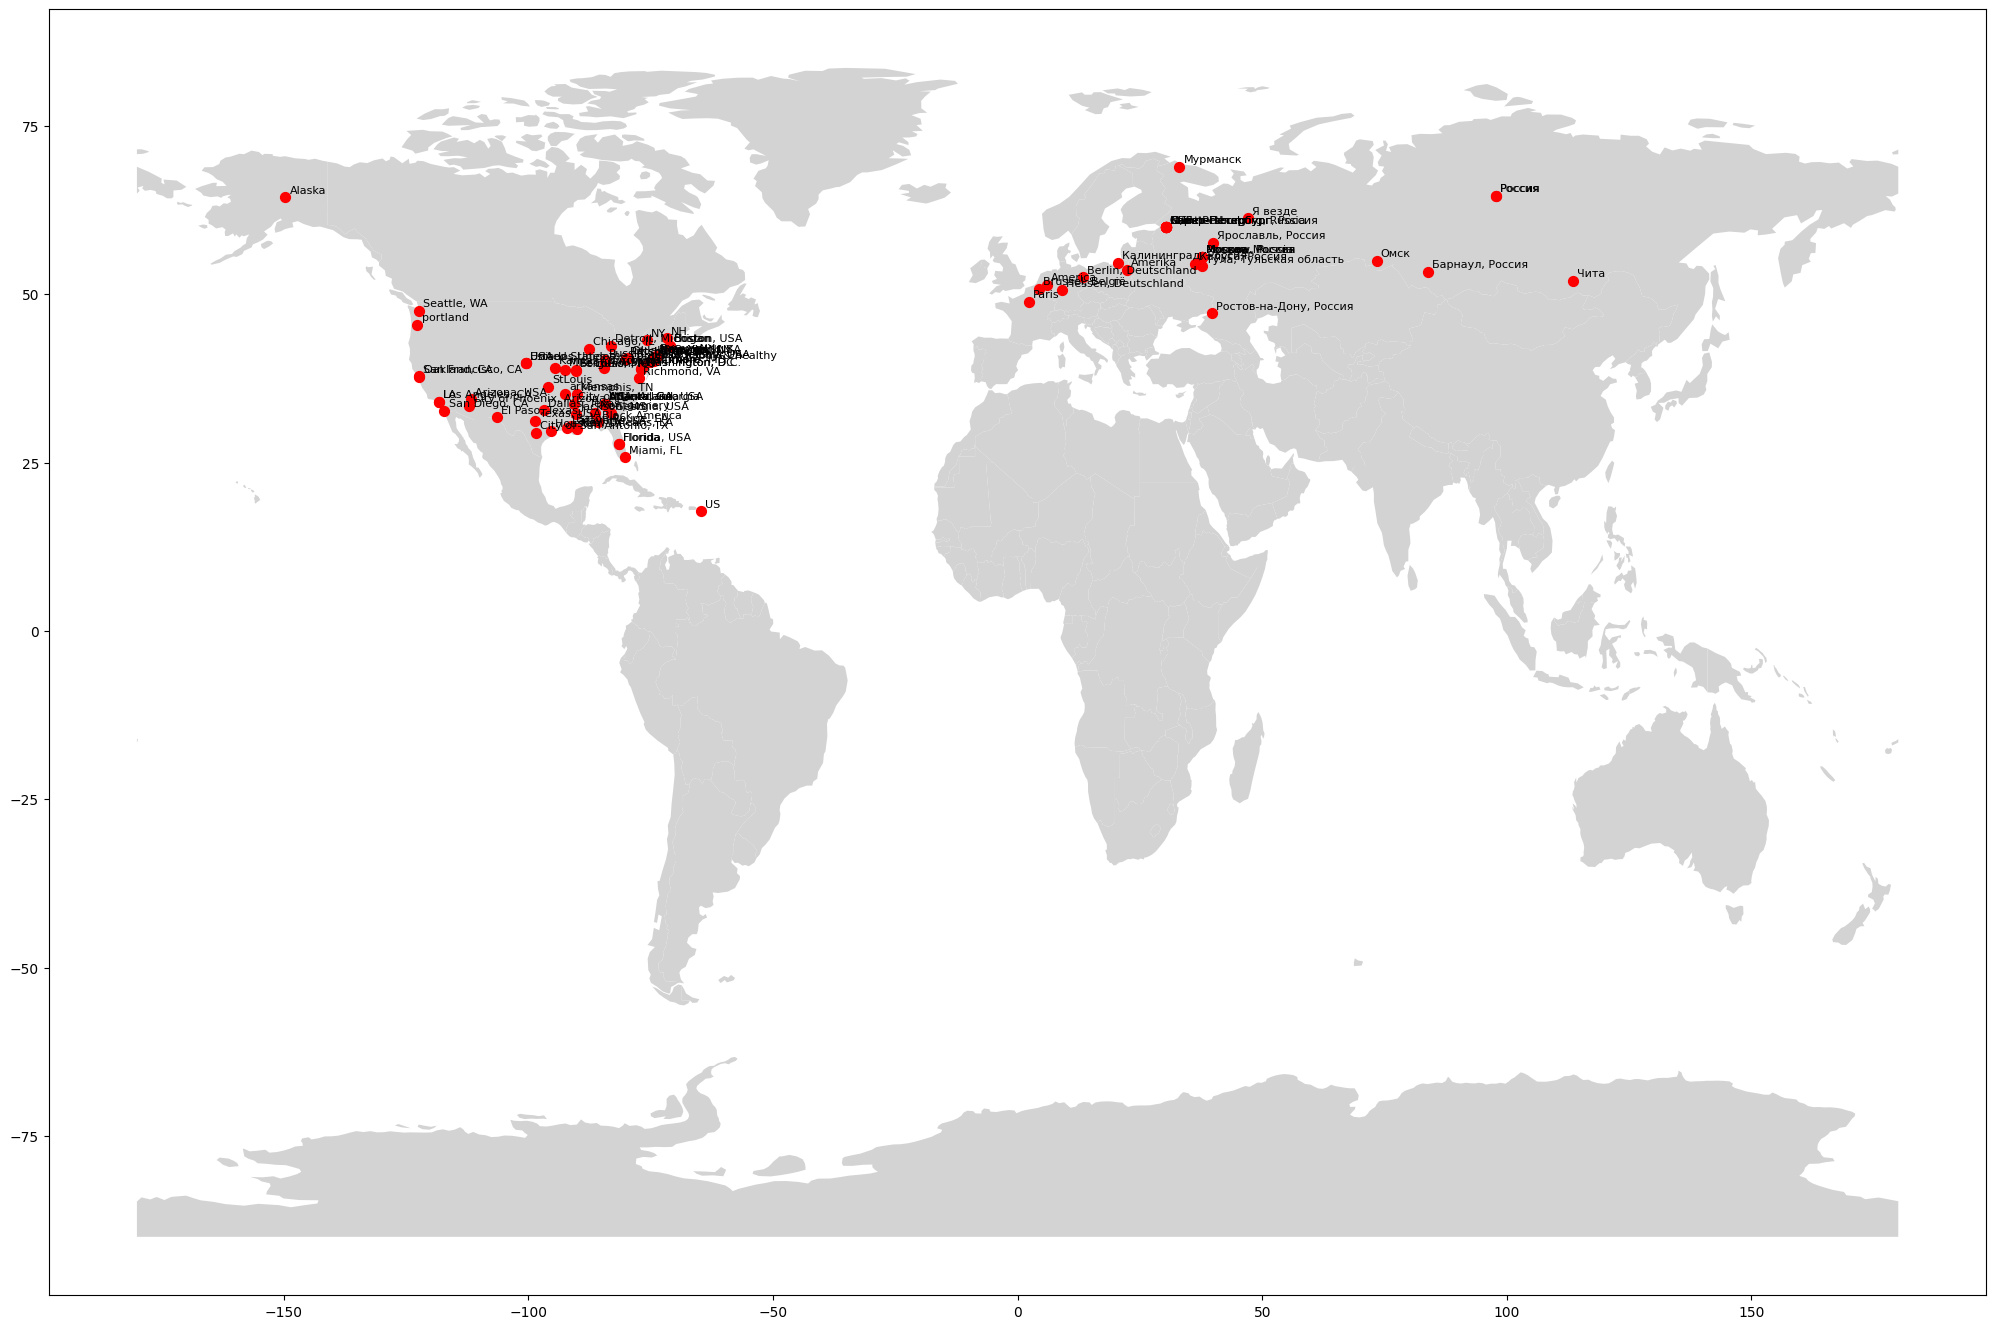

In [42]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# Example: City coordinates
cities = {
    user_location.iloc[i]['location']: user_location.iloc[i]['coordinates'] for i in range(len(user_location)) if user_location.iloc[i]['coordinates'] is not None
}

# Convert coordinates to Point objects
geometry = [Point(lon, lat) for lat, lon in cities.values()]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(geometry=geometry, index=cities.keys(), crs='EPSG:4326')

# Load world map data
world = gpd.read_file('./shapes/ne_110m_admin_0_countries.shp')

# Plot world map
world.plot(figsize=(25, 18), color='lightgrey')

# Plot city coordinates
gdf.plot(ax=plt.gca(), marker='o', color='red', markersize=50)

# Add city names as labels
for idx, row in gdf.iterrows():
    plt.annotate(idx, (row.geometry.x, row.geometry.y), xytext=(3, 3), textcoords='offset points', fontsize=8)

plt.show()
